

## RECONSTRUCTION OF ECG SIGNAL WITH DIFFERENT NOISE LEVELS


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

##Separeting train, validation and test data

In [6]:
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.models import Model

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]


x_train_data, x_val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=21)
x_train_data, x_test_data, train_labels, test_labels = train_test_split(x_train_data, train_labels, test_size=0.25, random_state=21)

min_val = tf.reduce_min(x_train_data)
max_val = tf.reduce_max(x_train_data)

x_train_data = (x_train_data - min_val) / (max_val - min_val)
x_val_data = (x_val_data - min_val) / (max_val - min_val)
x_test_data = (x_test_data - min_val) / (max_val - min_val)

x_train_data = np.array(tf.cast(x_train_data, tf.float32))
x_val_data = np.array(tf.cast(x_val_data, tf.float32))
x_test_data = np.array(tf.cast(x_test_data, tf.float32))

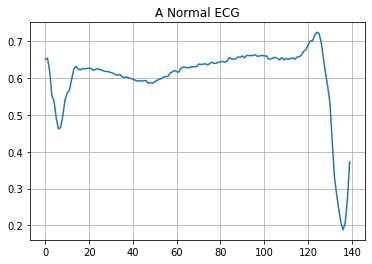

In [3]:
plt.grid()
plt.plot(np.arange(x_train_data.shape[1]), x_train_data[1])
plt.title("A Normal ECG")
plt.show()

## Add of noise in data

In [8]:
list_of_noise_range=[0.0,0.25] #,0.5,0.75,1.0]

for noise_factor in list_of_noise_range:
  x_train_noise_factor = x_train_data + noise_factor * tf.random.normal(shape=x_train_data.shape) 
  x_val_noise_factor = x_val_data + noise_factor * tf.random.normal(shape=x_val_data.shape) 
  x_test_noise_factor = x_test_data + noise_factor * tf.random.normal(shape=x_test_data.shape) 

  #x_train_noise_factor = np.array(tf.clip_by_value( x_train_noise_factor, clip_value_min=0., clip_value_max=1.))
  #x_test_noise_factor = np.array(tf.clip_by_value( x_test_noise_factor, clip_value_min=0., clip_value_max=1.))
  #x_val_noise_factor =np.array(tf.clip_by_value( x_val_noise_factor, clip_value_min=0., clip_value_max=1.))

In [9]:
x_val_noise_factor.shape

TensorShape([1000, 140])

In [11]:
x_test_data.shape

(1000, 140)

In [12]:
np.array(x_val_data).shape

(1000, 140)

## Make the autoencoder model 

In [36]:
def Reshape_data(x):
  x=np.array(x)
  n=x.shape[1]
  x = x.reshape(-1, 1, n)
  return x


In [83]:
def Create_a_model(X):
  X=Reshape_data(X)
  encoder_inputs = layers.Input(shape=(X.shape[1:]))
  x=layers.LSTM(140,input_shape=(X.shape[1:]), activation='relu')
  #x=layers.Dense(75, activation="relu")(encoder_inputs)
  x=layers.Dense(32, activation="relu")(encoder_inputs)
  x=layers.Dense(16, activation="relu")(x)
  x=layers.Dense(8, activation="relu")(x)

  decoder = layers.Dense(16, activation="relu")(x)
  x=layers.Dense(32, activation="relu")(x)
  #x=layers.Dense(75, activation="relu")(x)
  x=layers.Dense(140, activation="sigmoid")(x)

  autoencoder =Model(inputs=encoder_inputs,outputs=x)

  autoencoder.summary()
  
  autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-1), loss='mae')
  return autoencoder



In [84]:
autoencoder=Create_a_model(x_train_data)


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 140)]          0         
_________________________________________________________________
dense_45 (Dense)             (None, 1, 32)             4512      
_________________________________________________________________
dense_46 (Dense)             (None, 1, 16)             528       
_________________________________________________________________
dense_47 (Dense)             (None, 1, 8)              136       
_________________________________________________________________
dense_49 (Dense)             (None, 1, 32)             288       
_________________________________________________________________
dense_50 (Dense)             (None, 1, 140)            4620      
Total params: 10,084
Trainable params: 10,084
Non-trainable params: 0
_______________________________________________________

In [85]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [89]:
history = autoencoder.fit(Reshape_data(x_train_noise_factor),Reshape_data(x_train_data), 
          epochs=20, 
          batch_size=32,
          validation_data=(Reshape_data(x_val_noise_factor), Reshape_data(x_val_data)),
          shuffle=True, workers=-1)

Epoch 1/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0280
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0276 - val_loss: 0.0280
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0279
Epoch 4/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.0279
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0271 - val_loss: 0.0278
Epoch 7/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0277
Epoch 8/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0275
Epoch 9/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0275
Epoch 10/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.0272
Epoch 11/20
94/94 [

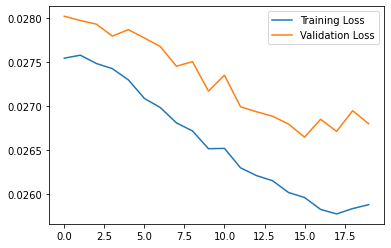

In [90]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

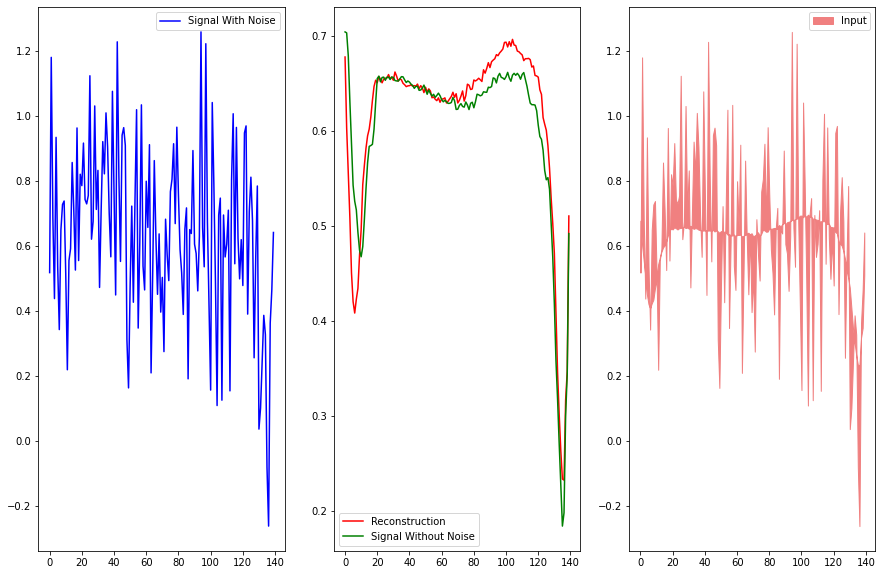

In [91]:
#encoded_data = autoencoder.encoder().numpy()
decoded_data = autoencoder.predict(Reshape_data(x_test_noise_factor))
decoded_data=decoded_data.reshape(decoded_data.shape[0],decoded_data.shape[2])

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.plot(x_test_noise_factor[0], 'b')
plt.legend(labels=["Signal With Noise"])
plt.subplot(132)
plt.plot(decoded_data[0], 'r')
plt.plot(x_test_data[0],'g')
plt.legend(labels=["Reconstruction","Signal Without Noise"])
plt.subplot(133)
plt.fill_between(np.arange(140), decoded_data[0], x_test_noise_factor[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.savefig("Signals.png")
plt.show()
